In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import zipfile
from torch.utils.data.sampler import SubsetRandomSampler


%matplotlib inline

In [2]:
train_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/"

In [3]:
class FaceDataset(Dataset):
    
    def __init__(self, file_list, dir, transform = None):
        self.file_list = file_list
        self.dir = dir
        self.transform = transform
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        
        img = self.transform(img)
        img = img.numpy()
            
        return img.astype('float32')

data_transform = transforms.Compose([
    transforms.Resize(260),
    transforms.RandomCrop(256),
    transforms.ToTensor()
])

face_files = os.listdir(train_dir)
face_dataset = FaceDataset(face_files,train_dir,data_transform)

validation_split = .2
shuffle_dataset = True

dataset_size = len(face_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

trainloader = DataLoader(face_dataset, batch_size = 32,num_workers=4,sampler = train_sampler)
valloader = DataLoader(face_dataset, batch_size = 32,num_workers=4,sampler = valid_sampler)

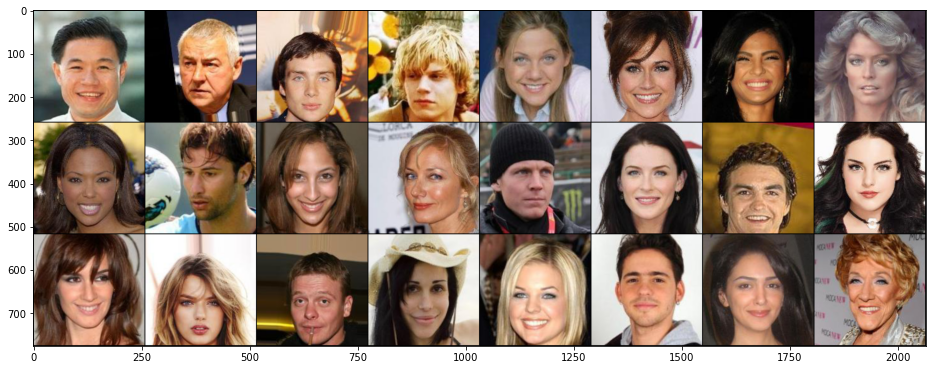

In [4]:

samples = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

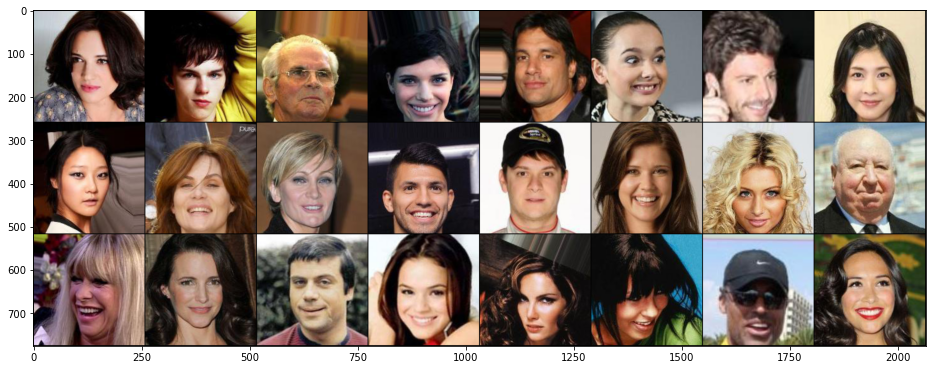

In [5]:
samples = iter(valloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [6]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [7]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,3,(1,1),padding=(1,1))
        self.conv2 = nn.Conv2d(32,32,4,(2,2),padding=(1,1))
        self.conv3 = nn.Conv2d(32,64,4,(2,2),padding=(1,1))
        self.conv4 = nn.Conv2d(64,128,4,(2,2),padding=(1,1))
        self.conv5 = nn.Conv2d(128,256,4,(2,2),padding=(1,1))
        self.conv6 = nn.Conv2d(256,512,4,(2,2),padding=(1,1))
        self.conv_mu = nn.Conv2d(512,512,4,(2,2),padding=(1,1))
        self.conv_logvar = nn.Conv2d(512,512,4,(2,2),padding=(1,1))
        
    def forward(self,x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        
        return mu,logvar

In [8]:
class Decoder(nn.Module):
    
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.t_conv1 = nn.ConvTranspose2d(512,512,1,(1,1))
        self.t_conv2 = nn.ConvTranspose2d(512,512,4,(2,2),padding=(1,1))
        self.t_conv3 = nn.ConvTranspose2d(512,256,4,(2,2),padding=(1,1))
        self.t_conv4 = nn.ConvTranspose2d(256,128,4,(2,2),padding=(1,1))
        self.t_conv5 = nn.ConvTranspose2d(128,64,4,(2,2),padding=(1,1))
        self.t_conv6 = nn.ConvTranspose2d(64,32,4,(2,2),padding=(1,1))
        self.t_conv7 = nn.ConvTranspose2d(32,3,4,(2,2),padding=(1,1))
        
    def forward(self,x):
        
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = F.relu(self.t_conv4(x))
        x = F.relu(self.t_conv5(x))
        x = F.relu(self.t_conv6(x))
        x = torch.sigmoid(self.t_conv7(x))
        
        return x

In [9]:
class VAE(nn.Module):

  def __init__(self):
    super(VAE, self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()

  def reparametrize(self,mu,logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.empty_like(std).normal_()
    return eps.mul(std).add_(mu)
  
  def forward(self,x):
    
    mu,logvar = self.encoder(x)
    z = self.reparametrize(mu,logvar)
    x = self.decoder(z)
   
    return (x,mu,logvar)

vae = VAE()
vae = vae.to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_mu): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_logvar): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (decoder): Decoder(
    (t_conv1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
    (t_conv2): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (t_conv4): ConvTranspose2d(256, 128

In [10]:
def vae_loss(recon_x,x,mu,logvar):

  bce_loss = F.binary_cross_entropy(recon_x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]),x.view(-1,x.shape[1]*x.shape[2]*x.shape[3]),reduction='sum')
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return KLD + bce_loss

In [11]:
optimizer = torch.optim.Adam(vae.parameters(),0.001,weight_decay=1e-5)

In [14]:
vae.train()

train_loss_avg = []
num_epochs = 10

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    running_loss = 0.0
    
    for image_batch in trainloader:
        
        image_batch = image_batch.to(device)

        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
        
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        running_loss += loss.item()
        num_batches += 1
        
        if num_batches % 200 == 0:
            print(num_batches,running_loss/200)
            running_loss = 0.0
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1,num_epochs, train_loss_avg[-1]))

Training ...
200 3094407.6525
400 3106949.41125
600 3096295.2825
800 3090072.37875
1000 3101845.1125
1200 3107171.385
1400 3103527.77625
1600 3098781.08625
1800 3106759.65875
2000 3104110.78125
2200 3105053.20875
2400 3092691.415
2600 3108719.015
2800 3105195.205
3000 3092498.49125
3200 3098776.21375
3400 3091518.42875
3600 3111844.9675
3800 3094047.8375
4000 3088900.495
4200 3092661.70125
4400 3099735.5375
4600 3098663.7325
4800 3098079.50625
5000 3088552.3
Epoch [1 / 3] average reconstruction error: 3099202.539191
200 3101121.6725
400 3107681.09
600 3098238.45125
800 3091706.475
1000 3100613.6325
1200 3107521.28625
1400 3087329.9725
1600 3093647.16375
1800 3103660.79875
2000 3087786.81375
2200 3099689.6925
2400 3104375.3575
2600 3088704.6225
2800 3097376.6475
3000 3098163.16375
3200 3109604.94
3400 3095798.16125
3600 3098942.28125
3800 3106045.25375
4000 3098325.17875
4200 3104426.515
4400 3078709.1475
4600 3104093.725
4800 3104476.08625
5000 3088315.3775
Epoch [2 / 3] average recons

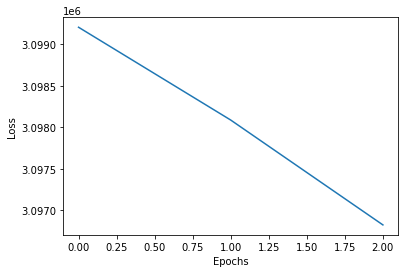

In [15]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

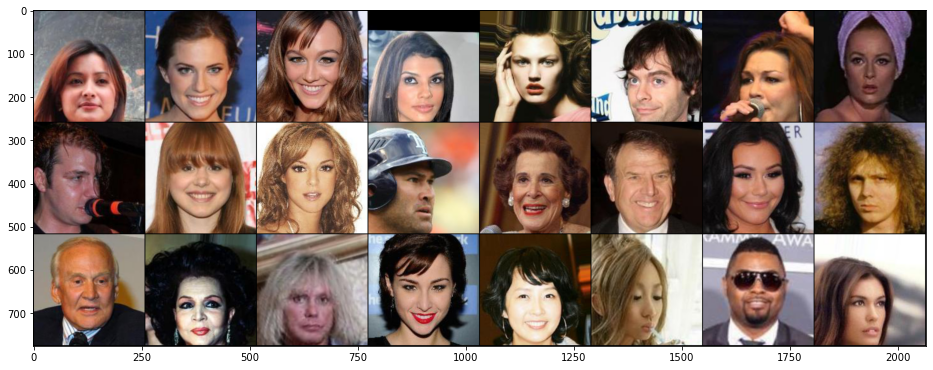

In [16]:
import numpy

samples = iter(trainloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

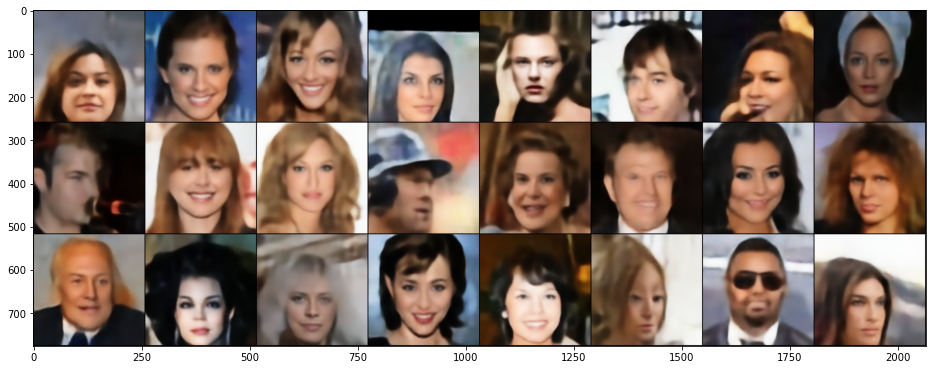

In [17]:
samples = samples.to(device='cuda', dtype=torch.float)
Results,_,_a = vae(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

Original images


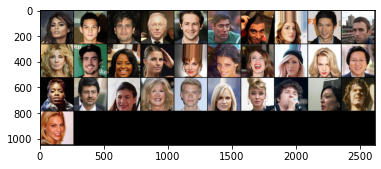

VAE reconstruction:


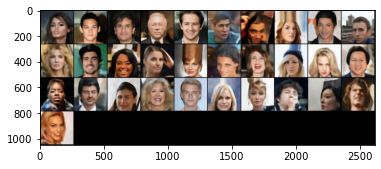

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()


def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images = iter(valloader).next()


print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

print('VAE reconstruction:')
visualise_output(images, vae)

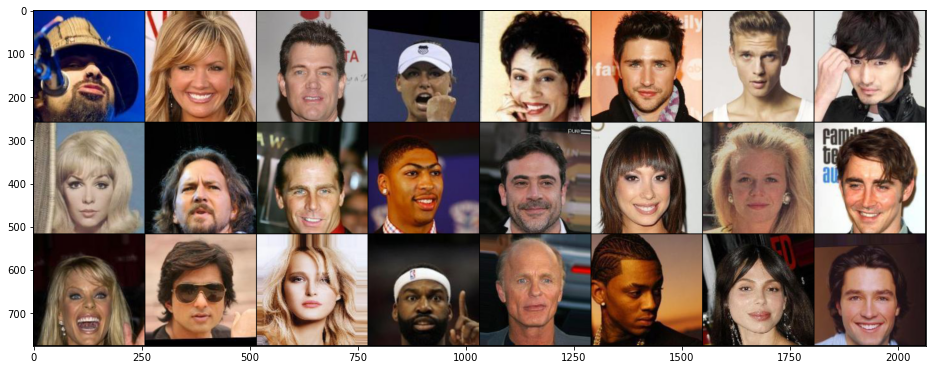

In [53]:
import numpy

samples = iter(valloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

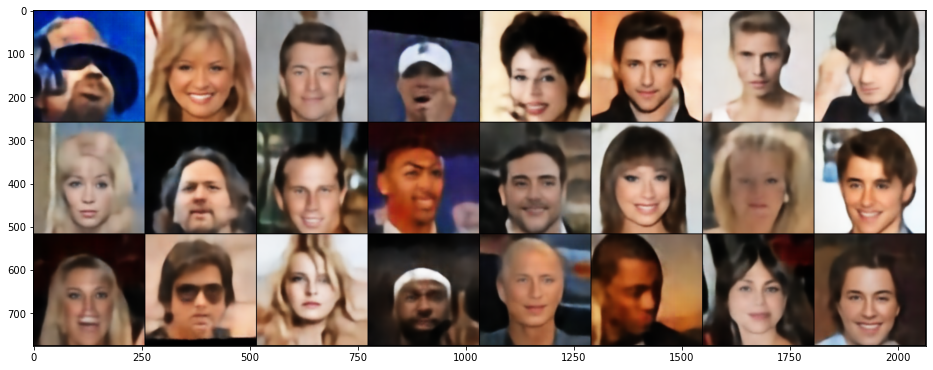

In [55]:
samples = samples.to(device='cuda', dtype=torch.float)
Results,_,_a = vae(samples)
Resluts = Results.to('cpu')
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(Results[:24])
grid_imgs = grid_imgs.to('cpu')
np_grid_imgs = grid_imgs.detach().numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

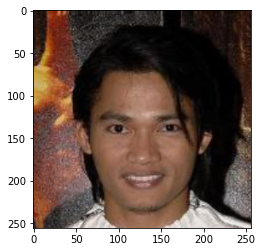

In [50]:
i1 = samples[13].to('cpu')
i2 = samples[14].to('cpu')
plt.imshow(i1.permute(1, 2, 0))

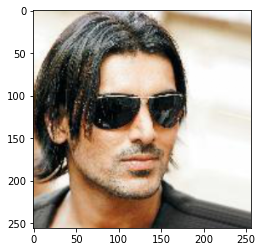

In [51]:
plt.imshow(i2.permute(1, 2, 0))

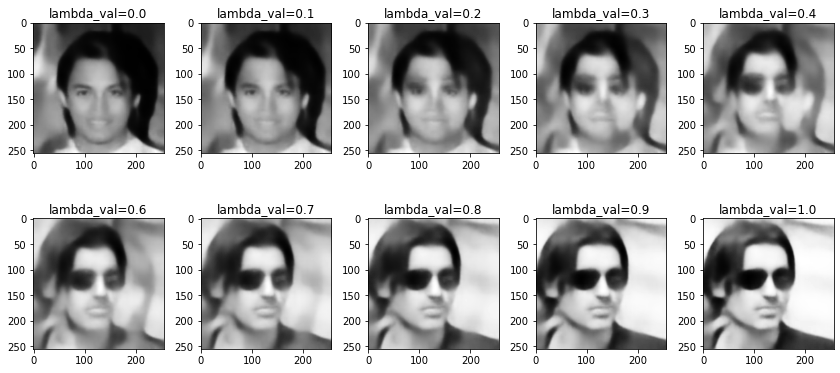

In [52]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
        
        img1 = img1.reshape((1,3,256,256))
        img2 = img2.reshape((1,3,256,256))
        # latent vector of first image
        img1 = img1.to(device)
        latent_1,_ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2,_ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae,i2,i1)
   
    inter_image = to_img(inter_image)
    
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show()